Load some utils function + annotations first

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from utils import load_image_annotations, display_image_with_keypoints

In [3]:
annotations = json.load(open("/root/data/gtsf_2.0/registration_test/gtsf_in_air_labels.json"))

In this example, we are going to load ~10 images as reference and use the mean of prediction to get the keypoints

In [19]:
reference_masks = []
reference_kp_map = []
for ann in annotations[:1]:
    _, static_mask, _, static_kp_map = load_image_annotations(ann, new_shape=(512, 512))
    reference_masks.append(np.fliplr(static_mask))
    reference_kp_map.append(np.fliplr(static_kp_map))

In [20]:
print("Number of reference images: {}".format(len(reference_masks)))

Number of reference images: 1


Looping through all the examples.

In [21]:
from copy import copy

from dipy.viz import regtools

from utils import translate_moving, register, display_warped_keypoints, display_pairs_with_keypoints, calculate_errors
from utils import display_keypoints_gt_pred
from utils import create_mask
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [22]:
display = False
min_hsv = (50, 100, 100)
max_hsv = (80, 255, 255)

In [23]:
files = glob.glob("/root/data/phase_I/small-pen-test-site/1/2019-03-13/*")

Creating scale space from the moving image. Levels: 5. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 5. Sigma factor: 0.200000.
Optimizing level 4
Optimizing level 3
Optimizing level 2
Optimizing level 1
Optimizing level 0


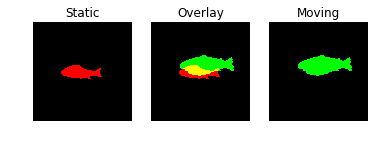

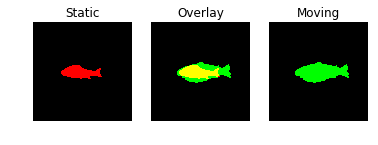

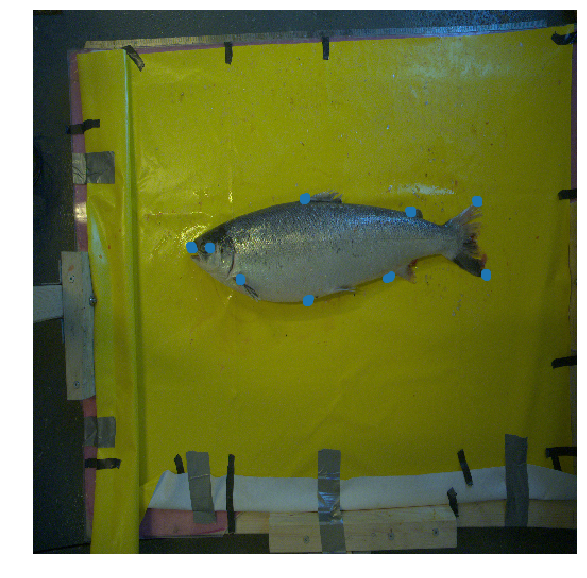

In [32]:
for f in files:
    # first let's create the mask
    image, mask = create_mask(f, min_hsv, max_hsv)
    mask = np.array(mask, dtype=np.uint8)
    mask = cv2.dilate(mask, np.ones((5, 5)))
    moving_mask = cv2.erode(mask, np.ones((5, 5)))
    
    for i in range(len(reference_masks)):
#         regtools.overlay_images(reference_masks[i], 
#                                 moving_mask, 
#                                 'Static', 'Overlay', 'Moving', 'input_images.png')
        
        moving_translated, translation_vector = translate_moving(static_mask, moving_mask)
        
#         regtools.overlay_images(reference_masks[i], 
#                                 moving_translated, 
#                                 'Static', 'Overlay', 'Moving', 'input_images.png')
        # register
        mapping = register(reference_masks[i], moving_translated)
        
        # warped keypoints
        warped_kp_map = mapping.transform_inverse(reference_kp_map[i], "linear")
        display_warped_keypoints(image, warped_kp_map, translation_vector)
        
    break
